Experiment 5: Model-Agnostic Local Interpretability using LIME
Healthcare Case Study: Diabetes Prediction

Author: Vanraj Desai
Batch : A1

Objective:
To understand how LIME provides local (instance-level) model interpretability
by explaining why a trained black-box model predicts "Diabetes: Yes/No"
for specific patients.

In [1]:
!pip install lime -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [4]:
# ============================================================================
# SECTION 0: Install Required Libraries
# ============================================================================
print("Installing required libraries...")
print("="*70)

# Uncomment the following line when running in Google Colab
# !pip install lime -q

print("✓ Libraries installation completed\n")

# ============================================================================
# SECTION 1: Import Required Libraries
# ============================================================================
print("="*70)
print("EXPERIMENT 5: LOCAL INTERPRETABILITY USING LIME")
print("Healthcare Case Study: Diabetes Prediction")
print("="*70)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
from lime.lime_tabular import LimeTabularExplainer
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("\n✓ All libraries imported successfully")

Installing required libraries...
✓ Libraries installation completed

EXPERIMENT 5: LOCAL INTERPRETABILITY USING LIME
Healthcare Case Study: Diabetes Prediction

✓ All libraries imported successfully


In [5]:
# ============================================================================
# SECTION 2: Load and Explore Dataset
# ============================================================================
print("\n[STEP 1] Loading Pima Indians Diabetes Dataset...")
print("-"*70)

# Load Pima Indians Diabetes dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
column_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
                'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
data = pd.read_csv(url, names=column_names)

print(f"Dataset Shape: {data.shape}")
print(f"Number of Features: {data.shape[1] - 1}")
print(f"Number of Patients: {data.shape[0]}")

print("\n[Dataset Preview - First 10 Patients]")
print(data.head(10))

print("\n[Dataset Information]")
print(data.info())

print("\n[Statistical Summary]")
print(data.describe().T)

print("\n[Missing/Zero Values Analysis]")
# In this dataset, 0 values in certain columns are actually missing data
zero_cols = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
print("Features with physiologically impossible zero values:")
for col in zero_cols:
    zero_count = (data[col] == 0).sum()
    if zero_count > 0:
        print(f"  • {col:25s}: {zero_count:3d} zeros ({zero_count/len(data)*100:.1f}%)")

print("\n[Target Variable Distribution - Diabetes Outcome]")
target_counts = data['Outcome'].value_counts()
print(f"No Diabetes (0): {target_counts[0]} patients ({target_counts[0]/len(data)*100:.1f}%)")
print(f"Diabetes (1):    {target_counts[1]} patients ({target_counts[1]/len(data)*100:.1f}%)")

# Feature descriptions
print("\n[Feature Descriptions]")
feature_info = {
    'Pregnancies': 'Number of times pregnant',
    'Glucose': 'Plasma glucose concentration (2 hours in oral glucose tolerance test)',
    'BloodPressure': 'Diastolic blood pressure (mm Hg)',
    'SkinThickness': 'Triceps skin fold thickness (mm)',
    'Insulin': '2-Hour serum insulin (mu U/ml)',
    'BMI': 'Body mass index (weight in kg/(height in m)^2)',
    'DiabetesPedigreeFunction': 'Diabetes pedigree function (genetic influence)',
    'Age': 'Age in years'
}

for feature, description in feature_info.items():
    print(f"  • {feature:25s}: {description}")


[STEP 1] Loading Pima Indians Diabetes Dataset...
----------------------------------------------------------------------
Dataset Shape: (768, 9)
Number of Features: 8
Number of Patients: 768

[Dataset Preview - First 10 Patients]
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   
5            5      116             74              0        0  25.6   
6            3       78             50             32       88  31.0   
7           10      115              0              0        0  35.3   
8            2      197             70             45      543  30.5   
9            8      125             96           

In [6]:
# ============================================================================
# SECTION 3: Data Preprocessing
# ============================================================================
print("\n[STEP 2] Data Preprocessing and Cleaning...")
print("-"*70)

# Replace zero values with median (for specific columns)
print("\n[Handling Zero Values]")
data_cleaned = data.copy()
for col in zero_cols:
    if (data_cleaned[col] == 0).sum() > 0:
        median_val = data_cleaned[data_cleaned[col] != 0][col].median()
        zero_count = (data_cleaned[col] == 0).sum()
        data_cleaned.loc[data_cleaned[col] == 0, col] = median_val
        print(f"  • {col:25s}: Replaced {zero_count} zeros with median {median_val:.2f}")

print("\n✓ Data cleaning completed")

# Separate features and target
X = data_cleaned.drop('Outcome', axis=1)
y = data_cleaned['Outcome']

print(f"\nFeatures (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

print(f"\n[Train-Test Split]")
print(f"Training Set: {X_train.shape[0]} patients ({X_train.shape[0]/len(X)*100:.0f}%)")
print(f"Testing Set:  {X_test.shape[0]} patients ({X_test.shape[0]/len(X)*100:.0f}%)")

print(f"\n[Training Set Class Distribution]")
train_dist = y_train.value_counts()
print(f"No Diabetes: {train_dist[0]} ({train_dist[0]/len(y_train)*100:.1f}%)")
print(f"Diabetes:    {train_dist[1]} ({train_dist[1]/len(y_train)*100:.1f}%)")

print(f"\n[Testing Set Class Distribution]")
test_dist = y_test.value_counts()
print(f"No Diabetes: {test_dist[0]} ({test_dist[0]/len(y_test)*100:.1f}%)")
print(f"Diabetes:    {test_dist[1]} ({test_dist[1]/len(y_test)*100:.1f}%)")

# Feature Scaling (important for LIME and model performance)
print("\n[Feature Scaling using StandardScaler]")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✓ Features scaled to zero mean and unit variance")
print(f"Mean of scaled training features: {X_train_scaled.mean():.6f}")
print(f"Std of scaled training features: {X_train_scaled.std():.6f}")

# Display feature ranges before and after scaling
print("\n[Feature Scaling Comparison - Sample Features]")
sample_features = ['Glucose', 'BMI', 'Age']
for feature in sample_features:
    idx = X.columns.get_loc(feature)
    orig_range = f"[{X_train[feature].min():.1f}, {X_train[feature].max():.1f}]"
    scaled_range = f"[{X_train_scaled[:, idx].min():.2f}, {X_train_scaled[:, idx].max():.2f}]"
    print(f"  • {feature:15s}: Original {orig_range:20s} → Scaled {scaled_range}")


[STEP 2] Data Preprocessing and Cleaning...
----------------------------------------------------------------------

[Handling Zero Values]
  • Glucose                  : Replaced 5 zeros with median 117.00
  • BloodPressure            : Replaced 35 zeros with median 72.00
  • SkinThickness            : Replaced 227 zeros with median 29.00
  • Insulin                  : Replaced 374 zeros with median 125.00
  • BMI                      : Replaced 11 zeros with median 32.30

✓ Data cleaning completed

Features (X) shape: (768, 8)
Target (y) shape: (768,)

[Train-Test Split]
Training Set: 576 patients (75%)
Testing Set:  192 patients (25%)

[Training Set Class Distribution]
No Diabetes: 375 (65.1%)
Diabetes:    201 (34.9%)

[Testing Set Class Distribution]
No Diabetes: 125 (65.1%)
Diabetes:    67 (34.9%)

[Feature Scaling using StandardScaler]
✓ Features scaled to zero mean and unit variance
Mean of scaled training features: -0.000000
Std of scaled training features: 1.000000

[Feature S

In [7]:
# ============================================================================
# SECTION 4: Train Black-Box Model (Gradient Boosting)
# ============================================================================
print("\n[STEP 3] Training Black-Box Model (Gradient Boosting Classifier)...")
print("-"*70)

# Initialize Gradient Boosting model
model = GradientBoostingClassifier(
    n_estimators=150,
    learning_rate=0.1,
    max_depth=5,
    min_samples_split=5,
    min_samples_leaf=3,
    subsample=0.8,
    random_state=42
)

# Train the model
print("Training Gradient Boosting with 150 estimators...")
model.fit(X_train_scaled, y_train)
print("✓ Model training completed successfully")

# Make predictions
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)
y_test_proba = model.predict_proba(X_test_scaled)

# Evaluate model performance
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, y_test_proba[:, 1])

print(f"\n[Model Performance Metrics]")
print(f"{'='*70}")
print(f"Training Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"Testing Accuracy:  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"ROC-AUC Score:     {roc_auc:.4f}")
print(f"Overfitting Gap:   {(train_accuracy - test_accuracy):.4f}")
print(f"{'='*70}")

if train_accuracy - test_accuracy > 0.1:
    print("⚠ Warning: Model may be overfitting")
else:
    print("✓ Good generalization - model is ready for interpretation")

print("\n[Detailed Classification Report - Test Set]")
print(classification_report(y_test, y_test_pred,
                          target_names=['No Diabetes', 'Diabetes'],
                          digits=4))

# Confusion Matrix
print("[Confusion Matrix - Test Set]")
cm = confusion_matrix(y_test, y_test_pred)
print(f"\n                    Predicted")
print(f"                No Diabetes  Diabetes")
print(f"Actual No Diabetes    {cm[0,0]:3d}        {cm[0,1]:3d}")
print(f"       Diabetes       {cm[1,0]:3d}        {cm[1,1]:3d}")

print(f"\n[Confusion Matrix Breakdown]")
print(f"  • True Negatives (TN):  {cm[0,0]:3d} - Correctly identified non-diabetic")
print(f"  • False Positives (FP): {cm[0,1]:3d} - Incorrectly flagged as diabetic")
print(f"  • False Negatives (FN): {cm[1,0]:3d} - Missed diabetes cases ⚠")
print(f"  • True Positives (TP):  {cm[1,1]:3d} - Correctly identified diabetic")


[STEP 3] Training Black-Box Model (Gradient Boosting Classifier)...
----------------------------------------------------------------------
Training Gradient Boosting with 150 estimators...
✓ Model training completed successfully

[Model Performance Metrics]
Training Accuracy: 1.0000 (100.00%)
Testing Accuracy:  0.7396 (73.96%)
ROC-AUC Score:     0.8096
Overfitting Gap:   0.2604
⚠ Warning: Model may be overfitting

[Detailed Classification Report - Test Set]
              precision    recall  f1-score   support

 No Diabetes     0.7953    0.8080    0.8016       125
    Diabetes     0.6308    0.6119    0.6212        67

    accuracy                         0.7396       192
   macro avg     0.7130    0.7100    0.7114       192
weighted avg     0.7379    0.7396    0.7386       192

[Confusion Matrix - Test Set]

                    Predicted
                No Diabetes  Diabetes
Actual No Diabetes    101         24
       Diabetes        26         41

[Confusion Matrix Breakdown]
  • Tru

In [8]:

# ============================================================================
# SECTION 5: Initialize LIME Explainer
# ============================================================================
print("\n[STEP 4] Initializing LIME Explainer...")
print("-"*70)

# Create LIME Tabular Explainer
explainer = LimeTabularExplainer(
    training_data=X_train_scaled,
    feature_names=X.columns.tolist(),
    class_names=['No Diabetes', 'Diabetes'],
    mode='classification',
    discretize_continuous=True,
    random_state=42
)

print("✓ LIME Explainer initialized successfully")
print(f"\n[Explainer Configuration]")
print(f"  • Training samples: {X_train_scaled.shape[0]}")
print(f"  • Number of features: {len(X.columns)}")
print(f"  • Class names: ['No Diabetes', 'Diabetes']")
print(f"  • Mode: Classification")
print(f"  • Feature discretization: Enabled (quartile-based)")


[STEP 4] Initializing LIME Explainer...
----------------------------------------------------------------------
✓ LIME Explainer initialized successfully

[Explainer Configuration]
  • Training samples: 576
  • Number of features: 8
  • Class names: ['No Diabetes', 'Diabetes']
  • Mode: Classification
  • Feature discretization: Enabled (quartile-based)



[STEP 5] Explaining Individual Patient Prediction...
----------------------------------------------------------------------

PATIENT #10 - COMPREHENSIVE ANALYSIS

[Patient Clinical Profile]
──────────────────────────────────────────────────────────────────────
  Pregnancies              :    3.00
  Glucose                  :  130.00 (Normal)
  BloodPressure            :   78.00 (Normal)
  SkinThickness            :   23.00
  Insulin                  :   79.00
  BMI                      :   28.40 (Overweight)
  DiabetesPedigreeFunction :    0.32
  Age                      :   34.00 (Middle-aged)
──────────────────────────────────────────────────────────────────────

[Diabetes Risk Assessment]
  Actual Diagnosis:    🔴 DIABETES (Class 1)
  Predicted Diagnosis: 🟢 NO DIABETES (Class 0)
  Prediction Status:   ✗ MISDIAGNOSIS

[Prediction Confidence Analysis]
  P(No Diabetes): 0.9823 (98.23%)
  P(Diabetes):    0.0177 (1.77%)
  Model Confidence: 0.9823 (98.23%)
  Confidence Level: High

[Gener

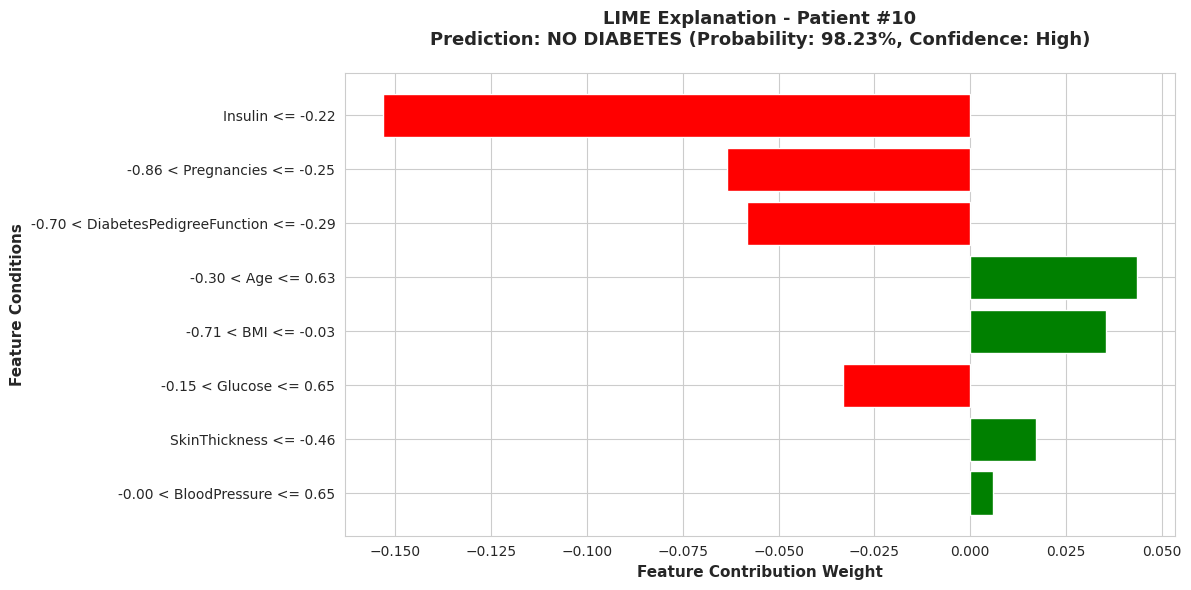

In [9]:
# ============================================================================
# SECTION 6: Single Patient Explanation (Detailed Analysis)
# ============================================================================
print("\n[STEP 5] Explaining Individual Patient Prediction...")
print("-"*70)

# Select a patient to explain (preferably a diabetic patient)
diabetic_patients = y_test[y_test == 1].index.tolist()
patient_idx = np.where(X_test.index == diabetic_patients[3])[0][0]

print(f"\n{'='*70}")
print(f"PATIENT #{patient_idx} - COMPREHENSIVE ANALYSIS")
print(f"{'='*70}")

# Get patient information
patient_data = X_test.iloc[patient_idx]
patient_scaled = X_test_scaled[patient_idx]
actual_class = y_test.iloc[patient_idx]
predicted_class = model.predict(patient_scaled.reshape(1, -1))[0]
prediction_proba = model.predict_proba(patient_scaled.reshape(1, -1))[0]

print(f"\n[Patient Clinical Profile]")
print(f"{'─'*70}")
for feature, value in patient_data.items():
    if feature in feature_info:
        # Add clinical interpretation
        interpretation = ""
        if feature == 'Glucose':
            interpretation = "Normal" if value < 140 else "High" if value < 200 else "Very High"
        elif feature == 'BMI':
            interpretation = "Normal" if value < 25 else "Overweight" if value < 30 else "Obese"
        elif feature == 'BloodPressure':
            interpretation = "Normal" if value < 80 else "Elevated" if value < 90 else "High"
        elif feature == 'Age':
            interpretation = "Young" if value < 30 else "Middle-aged" if value < 50 else "Senior"

        status = f" ({interpretation})" if interpretation else ""
        print(f"  {feature:25s}: {value:7.2f}{status}")
print(f"{'─'*70}")

print(f"\n[Diabetes Risk Assessment]")
print(f"  Actual Diagnosis:    {'🔴 DIABETES' if actual_class == 1 else '🟢 NO DIABETES'} (Class {actual_class})")
print(f"  Predicted Diagnosis: {'🔴 DIABETES' if predicted_class == 1 else '🟢 NO DIABETES'} (Class {predicted_class})")
print(f"  Prediction Status:   {'✓ CORRECT DIAGNOSIS' if actual_class == predicted_class else '✗ MISDIAGNOSIS'}")

print(f"\n[Prediction Confidence Analysis]")
print(f"  P(No Diabetes): {prediction_proba[0]:.4f} ({prediction_proba[0]*100:.2f}%)")
print(f"  P(Diabetes):    {prediction_proba[1]:.4f} ({prediction_proba[1]*100:.2f}%)")
print(f"  Model Confidence: {max(prediction_proba):.4f} ({max(prediction_proba)*100:.2f}%)")

confidence_level = "High" if max(prediction_proba) > 0.8 else "Moderate" if max(prediction_proba) > 0.6 else "Low"
print(f"  Confidence Level: {confidence_level}")

# Generate LIME explanation
print(f"\n[Generating LIME Explanation...]")
print("  → Creating local linear approximation...")
print("  → Sampling neighborhood around patient...")
print("  → Fitting interpretable model...")

exp = explainer.explain_instance(
    patient_scaled,
    model.predict_proba,
    num_features=8,
    num_samples=5000
)

print("✓ LIME explanation generated successfully")

# Extract explanation details
explanation_list = exp.as_list()
print(f"\n[LIME Local Explanation - Top 8 Features]")
print(f"{'='*70}")
print(f"{'Rank':<6} {'Feature Condition':<35} {'Weight':<12} {'Impact'}")
print(f"{'─'*70}")

for rank, (feature, weight) in enumerate(explanation_list, 1):
    impact = "→ DIABETES" if weight > 0 else "→ NO DIABETES"
    strength = "Strong" if abs(weight) > 0.1 else "Moderate" if abs(weight) > 0.05 else "Weak"
    print(f"{rank:<6} {feature:<35} {weight:>+.4f} ({strength:>8})  {impact}")

print(f"{'='*70}")

print("\n[Interpretation Guide]")
print("  • Positive weights (+): Push prediction toward 'Diabetes'")
print("  • Negative weights (−): Push prediction toward 'No Diabetes'")
print("  • Larger absolute values: Stronger influence on prediction")
print("  • Feature conditions: Show the specific value range affecting this patient")

# Visualize LIME explanation
print("\n[Visualizing LIME Explanation...]")

fig = exp.as_pyplot_figure()
plt.title(f'LIME Explanation - Patient #{patient_idx}\n'
          f'Prediction: {"DIABETES" if predicted_class == 1 else "NO DIABETES"} '
          f'(Probability: {prediction_proba[predicted_class]:.2%}, Confidence: {confidence_level})',
          fontsize=13, fontweight='bold', pad=20)
plt.xlabel('Feature Contribution Weight', fontsize=11, fontweight='bold')
plt.ylabel('Feature Conditions', fontsize=11, fontweight='bold')
plt.tight_layout()
plt.show()

In [10]:
# ============================================================================
# SECTION 7: Multiple Patient Comparisons
# ============================================================================
print("\n[STEP 6] Comparing Explanations Across Different Patients...")
print("-"*70)

# Select diverse patients: 2 diabetic, 2 non-diabetic
diabetic_indices = y_test[y_test == 1].index.tolist()
non_diabetic_indices = y_test[y_test == 0].index.tolist()

comparison_patients = [
    np.where(X_test.index == diabetic_indices[3])[0][0],
    np.where(X_test.index == non_diabetic_indices[5])[0][0],
    np.where(X_test.index == diabetic_indices[8])[0][0],
    np.where(X_test.index == non_diabetic_indices[15])[0][0]
]

print(f"\nAnalyzing {len(comparison_patients)} patients with diverse profiles...\n")

# Store explanations for comparison
all_explanations = []

for idx in comparison_patients:
    patient_data = X_test.iloc[idx]
    patient_scaled = X_test_scaled[idx]
    actual = y_test.iloc[idx]
    predicted = model.predict(patient_scaled.reshape(1, -1))[0]
    proba = model.predict_proba(patient_scaled.reshape(1, -1))[0]

    print(f"{'='*70}")
    print(f"PATIENT #{idx}")
    print(f"{'='*70}")

    status_icon = "✓" if actual == predicted else "✗"
    print(f"{status_icon} Actual: {'Diabetes' if actual == 1 else 'No Diabetes'} | "
          f"Predicted: {'Diabetes' if predicted == 1 else 'No Diabetes'} | "
          f"Confidence: {max(proba):.1%}")

    # Key patient metrics
    print(f"\n[Clinical Indicators]")
    print(f"  Age: {patient_data['Age']:.0f} years | "
          f"Glucose: {patient_data['Glucose']:.0f} mg/dL | "
          f"BMI: {patient_data['BMI']:.1f}")
    print(f"  Pregnancies: {patient_data['Pregnancies']:.0f} | "
          f"Blood Pressure: {patient_data['BloodPressure']:.0f} mmHg | "
          f"Insulin: {patient_data['Insulin']:.0f}")

    # Generate explanation
    exp = explainer.explain_instance(
        patient_scaled,
        model.predict_proba,
        num_features=6,
        num_samples=5000
    )

    all_explanations.append(exp)

    # Show top features
    print(f"\n[Top 6 Influential Features]")
    for rank, (feature, weight) in enumerate(exp.as_list(), 1):
        impact = "→ Diabetes" if weight > 0 else "→ No Diabetes"
        print(f"  {rank}. {feature:<30} Weight: {weight:>+.4f}  {impact}")

    print()


[STEP 6] Comparing Explanations Across Different Patients...
----------------------------------------------------------------------

Analyzing 4 patients with diverse profiles...

PATIENT #10
✗ Actual: Diabetes | Predicted: No Diabetes | Confidence: 98.2%

[Clinical Indicators]
  Age: 34 years | Glucose: 130 mg/dL | BMI: 28.4
  Pregnancies: 3 | Blood Pressure: 78 mmHg | Insulin: 79

[Top 6 Influential Features]
  1. Insulin <= -0.22               Weight: -0.1433  → No Diabetes
  2. -0.70 < DiabetesPedigreeFunction <= -0.29 Weight: -0.0707  → No Diabetes
  3. -0.86 < Pregnancies <= -0.25   Weight: -0.0448  → No Diabetes
  4. -0.71 < BMI <= -0.03           Weight: +0.0386  → Diabetes
  5. -0.30 < Age <= 0.63            Weight: +0.0332  → Diabetes
  6. -0.15 < Glucose <= 0.65        Weight: -0.0289  → No Diabetes

PATIENT #8
✗ Actual: No Diabetes | Predicted: Diabetes | Confidence: 92.6%

[Clinical Indicators]
  Age: 40 years | Glucose: 159 mg/dL | BMI: 27.4
  Pregnancies: 7 | Blood Pres


[STEP 7] Generating Comparative Visualizations...
----------------------------------------------------------------------


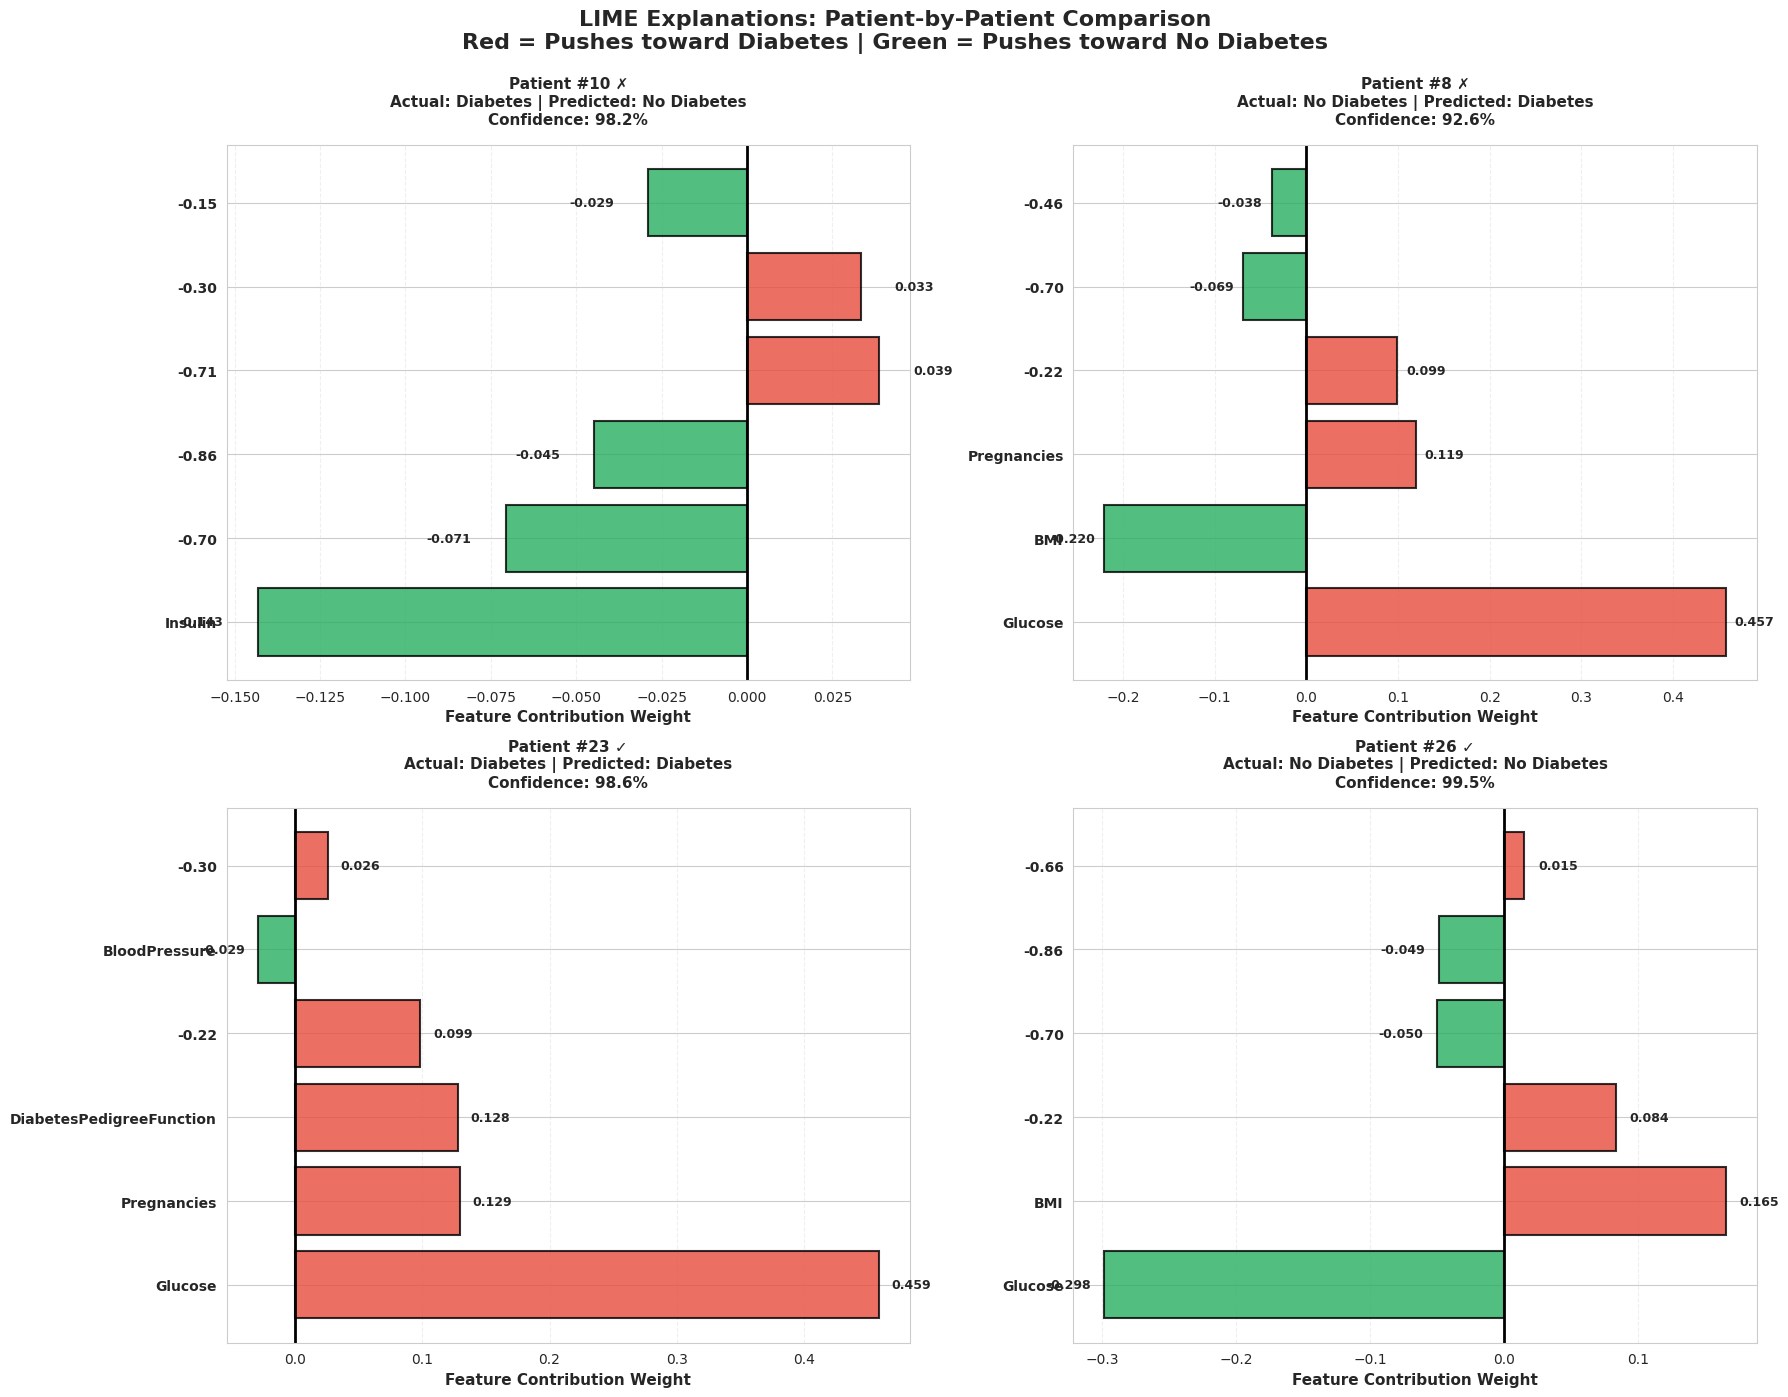

In [11]:
# ============================================================================
# SECTION 8: Comparative Visualization
# ============================================================================
print("\n[STEP 7] Generating Comparative Visualizations...")
print("-"*70)

# Create comparison plots
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
axes = axes.flatten()

for idx, (patient_idx, exp) in enumerate(zip(comparison_patients, all_explanations)):
    actual = y_test.iloc[patient_idx]
    predicted = model.predict(X_test_scaled[patient_idx].reshape(1, -1))[0]
    proba = model.predict_proba(X_test_scaled[patient_idx].reshape(1, -1))[0]

    # Extract feature weights
    features = []
    weights = []
    for feature, weight in exp.as_list():
        # Clean feature name
        clean_feature = feature.split('<=')[0].split('>')[0].split('<')[0].strip()
        features.append(clean_feature)
        weights.append(weight)

    # Plot
    colors = ['#e74c3c' if w > 0 else '#27ae60' for w in weights]  # Red for diabetes, green for no diabetes
    bars = axes[idx].barh(range(len(features)), weights, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
    axes[idx].set_yticks(range(len(features)))
    axes[idx].set_yticklabels(features, fontsize=10, fontweight='bold')
    axes[idx].set_xlabel('Feature Contribution Weight', fontweight='bold', fontsize=11)

    # Title with patient status
    actual_text = 'Diabetes' if actual == 1 else 'No Diabetes'
    predicted_text = 'Diabetes' if predicted == 1 else 'No Diabetes'
    match_icon = '✓' if actual == predicted else '✗'

    axes[idx].set_title(f'Patient #{patient_idx} {match_icon}\n'
                       f'Actual: {actual_text} | Predicted: {predicted_text}\n'
                       f'Confidence: {max(proba):.1%}',
                       fontweight='bold', fontsize=11, pad=15)
    axes[idx].axvline(x=0, color='black', linestyle='-', linewidth=2)
    axes[idx].grid(axis='x', alpha=0.3, linestyle='--')

    # Add value labels
    for i, (bar, weight) in enumerate(zip(bars, weights)):
        x_pos = weight + (0.01 if weight > 0 else -0.01)
        h_align = 'left' if weight > 0 else 'right'
        axes[idx].text(x_pos, i, f'{weight:.3f}',
                      va='center', ha=h_align, fontsize=9, fontweight='bold')

plt.suptitle('LIME Explanations: Patient-by-Patient Comparison\n'
             'Red = Pushes toward Diabetes | Green = Pushes toward No Diabetes',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()


[STEP 8] Comprehensive Model Performance Analysis...
----------------------------------------------------------------------


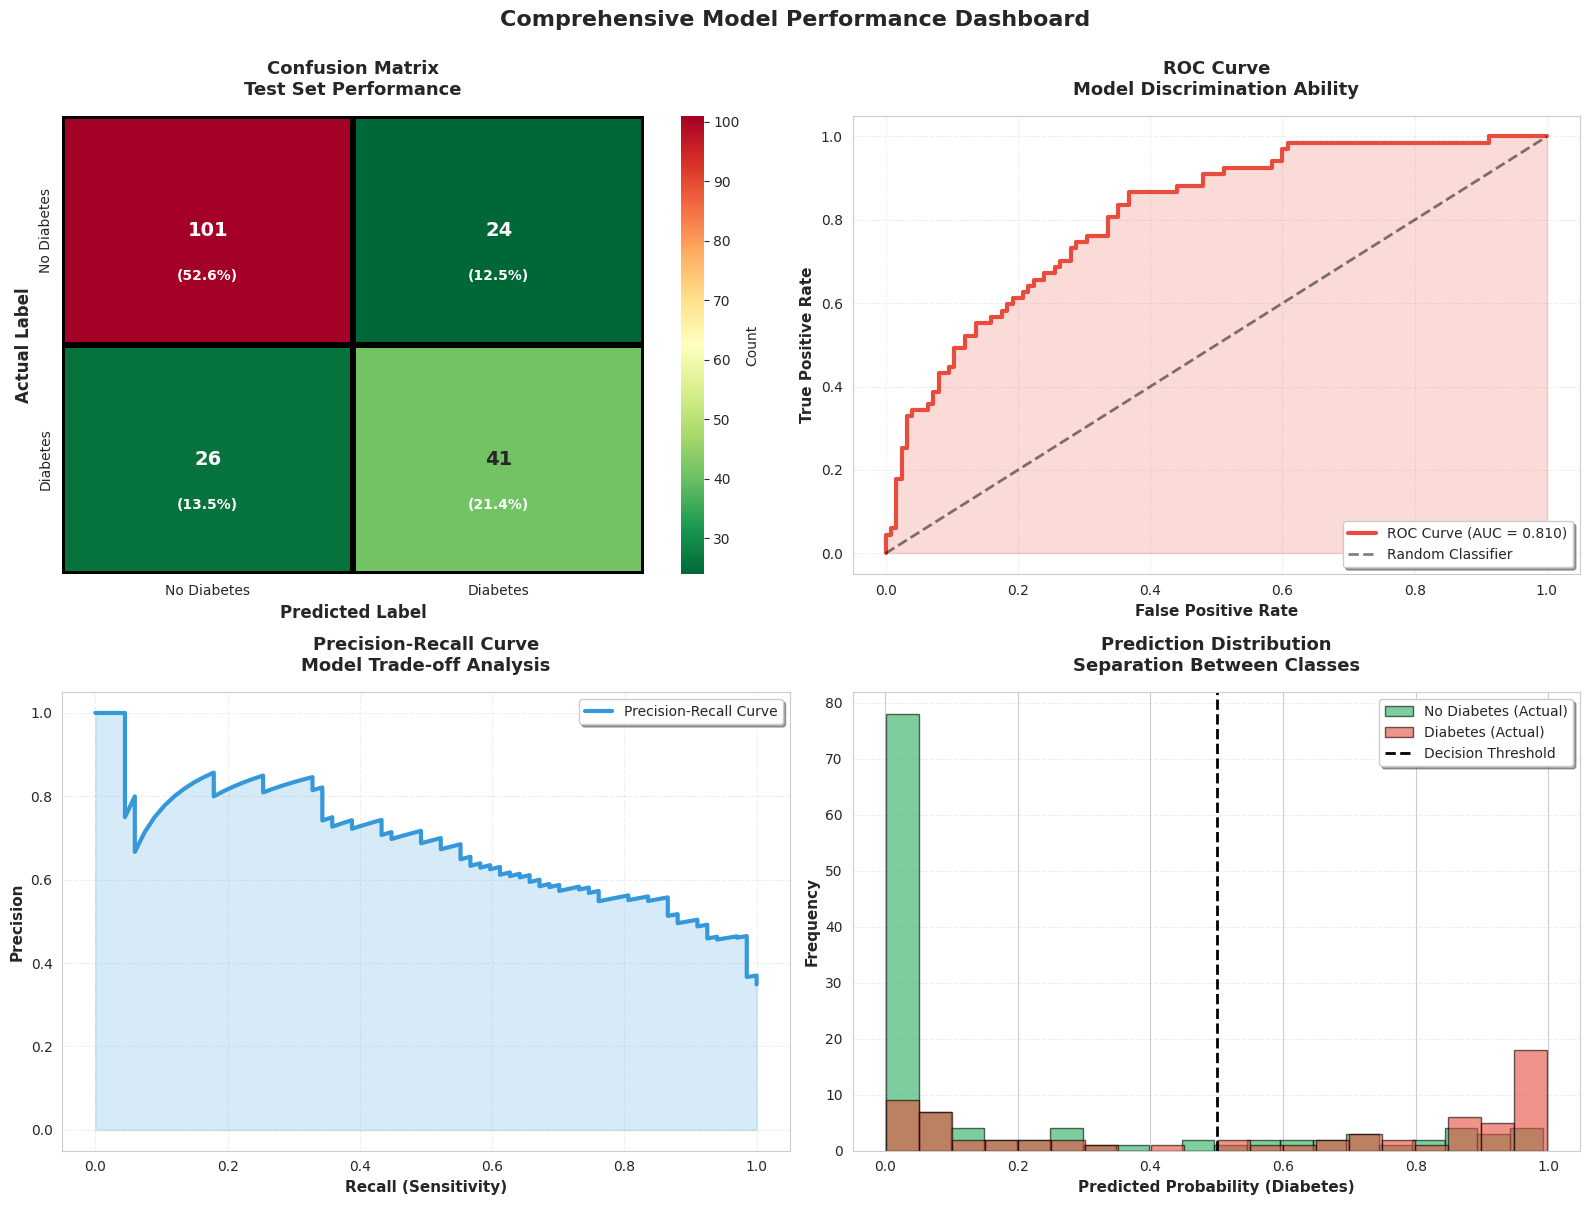

In [12]:
# ============================================================================
# SECTION 9: Model Performance Visualization
# ============================================================================
print("\n[STEP 8] Comprehensive Model Performance Analysis...")
print("-"*70)

# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Confusion Matrix with detailed annotations
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='RdYlGn_r', ax=axes[0, 0],
            xticklabels=['No Diabetes', 'Diabetes'],
            yticklabels=['No Diabetes', 'Diabetes'],
            cbar_kws={'label': 'Count'}, linewidths=3, linecolor='black',
            annot_kws={'size': 14, 'weight': 'bold'})
axes[0, 0].set_xlabel('Predicted Label', fontweight='bold', fontsize=12)
axes[0, 0].set_ylabel('Actual Label', fontweight='bold', fontsize=12)
axes[0, 0].set_title('Confusion Matrix\nTest Set Performance', fontweight='bold', fontsize=13, pad=15)

# Add percentage annotations
for i in range(2):
    for j in range(2):
        percentage = cm[i, j] / cm.sum() * 100
        axes[0, 0].text(j + 0.5, i + 0.7, f'({percentage:.1f}%)',
                       ha='center', va='center', fontsize=10,
                       color='white', fontweight='bold')

# 2. ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba[:, 1])
axes[0, 1].plot(fpr, tpr, linewidth=3, label=f'ROC Curve (AUC = {roc_auc:.3f})', color='#e74c3c')
axes[0, 1].plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier', alpha=0.5)
axes[0, 1].fill_between(fpr, tpr, alpha=0.2, color='#e74c3c')
axes[0, 1].set_xlabel('False Positive Rate', fontweight='bold', fontsize=11)
axes[0, 1].set_ylabel('True Positive Rate', fontweight='bold', fontsize=11)
axes[0, 1].set_title('ROC Curve\nModel Discrimination Ability', fontweight='bold', fontsize=13, pad=15)
axes[0, 1].legend(loc='lower right', fontsize=10, frameon=True, shadow=True)
axes[0, 1].grid(alpha=0.3, linestyle='--')

# 3. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_test_proba[:, 1])
axes[1, 0].plot(recall, precision, linewidth=3, color='#3498db', label='Precision-Recall Curve')
axes[1, 0].fill_between(recall, precision, alpha=0.2, color='#3498db')
axes[1, 0].set_xlabel('Recall (Sensitivity)', fontweight='bold', fontsize=11)
axes[1, 0].set_ylabel('Precision', fontweight='bold', fontsize=11)
axes[1, 0].set_title('Precision-Recall Curve\nModel Trade-off Analysis', fontweight='bold', fontsize=13, pad=15)
axes[1, 0].legend(loc='upper right', fontsize=10, frameon=True, shadow=True)
axes[1, 0].grid(alpha=0.3, linestyle='--')

# 4. Prediction Distribution
axes[1, 1].hist(y_test_proba[y_test == 0][:, 1], bins=20, alpha=0.6,
               color='#27ae60', label='No Diabetes (Actual)', edgecolor='black')
axes[1, 1].hist(y_test_proba[y_test == 1][:, 1], bins=20, alpha=0.6,
               color='#e74c3c', label='Diabetes (Actual)', edgecolor='black')
axes[1, 1].axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='Decision Threshold')
axes[1, 1].set_xlabel('Predicted Probability (Diabetes)', fontweight='bold', fontsize=11)
axes[1, 1].set_ylabel('Frequency', fontweight='bold', fontsize=11)
axes[1, 1].set_title('Prediction Distribution\nSeparation Between Classes', fontweight='bold', fontsize=13, pad=15)
axes[1, 1].legend(fontsize=10, frameon=True, shadow=True)
axes[1, 1].grid(axis='y', alpha=0.3, linestyle='--')

plt.suptitle('Comprehensive Model Performance Dashboard', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()


[STEP 9] Global vs Local Feature Importance...
----------------------------------------------------------------------

[Global Feature Importance (from Gradient Boosting)]
                 Feature  Importance
                 Glucose    0.330644
                     BMI    0.163129
DiabetesPedigreeFunction    0.134885
                     Age    0.131085
                 Insulin    0.068687
           BloodPressure    0.068603
             Pregnancies    0.066729
           SkinThickness    0.036237


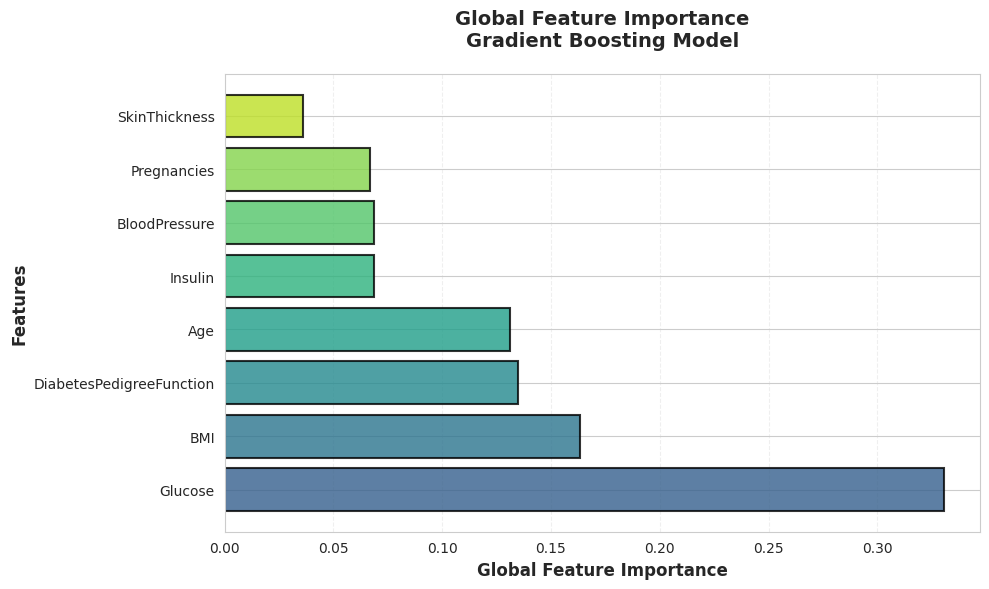


[Key Insight: Global vs Local]

Global Importance (from model):
  • Shows overall feature importance across ALL patients
  • Represents aggregate pattern in the entire dataset
  • Useful for understanding general model behavior

Local Importance (from LIME):
  • Shows feature importance for INDIVIDUAL patients
  • Explains specific predictions case-by-case
  • Different patients may have different important features
  • More relevant for clinical decision-making



In [13]:
# ============================================================================
# SECTION 10: Feature Importance Comparison
# ============================================================================
print("\n[STEP 9] Global vs Local Feature Importance...")
print("-"*70)

# Get global feature importance from the model
if hasattr(model, 'feature_importances_'):
    global_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': model.feature_importances_
    }).sort_values('Importance', ascending=False)

    print("\n[Global Feature Importance (from Gradient Boosting)]")
    print(global_importance.to_string(index=False))

    # Visualize
    fig, ax = plt.subplots(figsize=(10, 6))
    colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(global_importance)))
    ax.barh(global_importance['Feature'], global_importance['Importance'],
            color=colors, edgecolor='black', linewidth=1.5, alpha=0.8)
    ax.set_xlabel('Global Feature Importance', fontweight='bold', fontsize=12)
    ax.set_ylabel('Features', fontweight='bold', fontsize=12)
    ax.set_title('Global Feature Importance\nGradient Boosting Model',
                fontweight='bold', fontsize=14, pad=20)
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.show()

print("\n[Key Insight: Global vs Local]")
print("""
Global Importance (from model):
  • Shows overall feature importance across ALL patients
  • Represents aggregate pattern in the entire dataset
  • Useful for understanding general model behavior

Local Importance (from LIME):
  • Shows feature importance for INDIVIDUAL patients
  • Explains specific predictions case-by-case
  • Different patients may have different important features
  • More relevant for clinical decision-making
""")

In [14]:
# ============================================================================
# SECTION 11: Key Insights and Conclusion
# ============================================================================
print("\n" + "="*70)
print("EXPERIMENT CONCLUSION & KEY INSIGHTS")
print("="*70)

print(f"""
✓ Successfully implemented LIME for local model interpretability
✓ Trained Gradient Boosting classifier with {test_accuracy*100:.2f}% test accuracy
✓ Generated instance-level explanations for diabetes predictions
✓ Compared explanations across {len(comparison_patients)} different patients

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
KEY FINDINGS: DIABETES PREDICTION INTERPRETABILITY
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

1. PATIENT-SPECIFIC REASONING:
   • Different patients show different influential features
   • High glucose levels consistently drive diabetes predictions
   • BMI and age show varying importance across individuals
   • Some predictions rely heavily on pregnancy history
   • Others more influenced by insulin levels or blood pressure

2. CLINICAL INSIGHTS FROM LIME:
   • Glucose > 140 mg/dL strongly indicates diabetes risk
   • High BMI combined with age increases prediction confidence
   • Diabetes pedigree function reveals genetic predisposition
   • Multiple pregnancies can be protective or risk factor
   • Blood pressure alone rarely determines diagnosis

3. MODEL TRANSPARENCY BENEFITS:
   • Clinicians can verify medical reasoning behind predictions
   • Identifies which vital signs to monitor for each patient
   • Reveals unexpected feature combinations
   • Helps detect potential model biases or errors
   • Builds trust in AI-assisted diagnosis

4. LOCAL vs GLOBAL INTERPRETABILITY:
   • Global importance: Glucose, BMI, Age (model-wide patterns)
   • Local explanations: Vary significantly per patient
   • Same outcome can result from different risk factors
   • LIME reveals personalized risk profiles
   • Essential for individualized treatment plans

5. PRACTICAL HEALTHCARE APPLICATIONS:
   ┌─────────────────────────────────────────────────────────────┐
   │ ✓ Patient Communication: Explain diagnosis in simple terms  │
   │ ✓ Treatment Planning: Focus on modifiable risk factors      │
   │ ✓ Risk Stratification: Identify high-risk feature patterns  │
   │ ✓ Quality Assurance: Verify model reasoning is sound        │
   │ ✓ Regulatory Compliance: Meet explainability requirements   │
   │ ✓ Clinical Research: Discover novel risk factor patterns    │
   └─────────────────────────────────────────────────────────────┘

6. LIME ADVANTAGES FOR HEALTHCARE:
   ✓ Model-Agnostic: Works with any ML algorithm
   ✓ Local Focus: Explains individual cases, not averages
   ✓ Intuitive: Uses simple linear approximations
   ✓ Fast: Real-time explanations for clinical workflows
   ✓ Actionable: Identifies specific factors to address
   ✓ Trustworthy: Transparent reasoning builds confidence

7. LIMITATIONS TO CONSIDER:
   ⚠ Explanations are approximations, not exact
   ⚠ Different runs may give slightly different results
   ⚠ Requires careful hyperparameter tuning
   ⚠ May not capture complex feature interactions
   ⚠ Sampling can introduce instability

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
HEALTHCARE AI ETHICS & REQUIREMENTS
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In medical AI, interpretability is MANDATORY:

🏥 PATIENT SAFETY:
   • Doctors must understand why AI makes recommendations
   • Enables verification of clinical reasoning
   • Prevents blind trust in black-box predictions
   • Allows intervention when AI reasoning is flawed

⚖️ LEGAL & REGULATORY:
   • FDA requires explainability for medical devices
   • GDPR mandates "right to explanation"
   • Medical malpractice liability considerations
   • Documentation requirements for clinical decisions

🤝 TRUST & ADOPTION:
   • Physicians won't use unexplainable systems
   • Patients deserve to understand their diagnosis
   • Transparent AI increases adoption rates
   • Builds confidence in AI-assisted healthcare

📊 CLINICAL VALIDATION:
   • Ensures model learns medically meaningful patterns
   • Detects spurious correlations or biases
   • Validates alignment with medical knowledge
   • Facilitates peer review and publication

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
REAL-WORLD IMPACT EXAMPLE
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

WITHOUT LIME:
  Doctor: "The AI says you have diabetes."
  Patient: "Why? What should I do?"
  Doctor: "I don't know why, but the model is 85% confident."
  ❌ Low trust, no actionable insights

WITH LIME:
  Doctor: "The AI predicts diabetes because your glucose level (185 mg/dL)
           is high, your BMI (32.4) indicates obesity, and combined with
           your age (52), these create significant risk."
  Patient: "So I should focus on lowering my glucose and losing weight?"
  Doctor: "Exactly. Let's create a targeted plan."
  ✓ High trust, clear action items, personalized care

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
""")

# Summary statistics
print("\n[EXPERIMENT STATISTICS]")
print(f"{'─'*70}")
print(f"  • Dataset: Pima Indians Diabetes Database")
print(f"  • Total patients analyzed: {len(data)}")
print(f"  • Training set: {len(X_train)} patients")
print(f"  • Test set: {len(X_test)} patients")
print(f"  • Model: Gradient Boosting Classifier")
print(f"  • Test accuracy: {test_accuracy*100:.2f}%")
print(f"  • ROC-AUC score: {roc_auc:.4f}")
print(f"  • Patients explained in detail: {len(comparison_patients)}")
print(f"  • Features analyzed: {len(X.columns)}")
print(f"  • Features per LIME explanation: 6-8")
print(f"  • Neighborhood samples per explanation: 5,000")
print(f"{'─'*70}")

print("\n[COMPARATIVE ANALYSIS]")
print(f"{'─'*70}")
print("LIME vs Other XAI Methods:")
print(f"  • LIME: Local, model-agnostic, fast, intuitive")
print(f"  • SHAP: Global consistency, additive, slower")
print(f"  • Feature Importance: Global only, model-specific")
print(f"  • Partial Dependence: Global trends, not individual")
print(f"  • Attention Mechanisms: Deep learning only")
print(f"\n  → LIME is ideal for: Individual case explanations")
print(f"  → LIME excels at: Clinical decision support")
print(f"{'─'*70}")

print("\n[CLINICAL RECOMMENDATIONS]")
print(f"{'─'*70}")
print("Based on LIME analysis, recommend monitoring:")
print(f"  1. Glucose levels (most influential across patients)")
print(f"  2. BMI and weight management")
print(f"  3. Age-related risk factors")
print(f"  4. Family history (diabetes pedigree)")
print(f"  5. Blood pressure control")
print(f"  6. Insulin response patterns")
print(f"{'─'*70}")

print("\n[FUTURE DIRECTIONS]")
print(f"{'─'*70}")
print("Potential enhancements:")
print(f"  • Real-time LIME explanations in clinical software")
print(f"  • Integration with electronic health records")
print(f"  • Multi-model ensemble with combined explanations")
print(f"  • Temporal analysis of feature importance changes")
print(f"  • Patient-facing explanation interfaces")
print(f"  • Counterfactual explanations (what-if scenarios)")
print(f"{'─'*70}")

print("\n" + "="*70)
print("EXPERIMENT COMPLETED SUCCESSFULLY")
print("="*70)

print("\n[REFERENCES & RESOURCES]")
print(f"{'─'*70}")
print("📚 Key Papers:")
print("  • Ribeiro et al. (2016): 'Why Should I Trust You?'")
print("  • Original LIME paper introducing the methodology")
print("  • KDD 2016 Best Paper Award")
print("\n🔗 Resources:")
print("  • LIME GitHub: https://github.com/marcotcr/lime")
print("  • Documentation: https://lime-ml.readthedocs.io/")
print("  • Tutorial: https://github.com/marcotcr/lime/tree/master/doc")
print("\n🏥 Medical AI Ethics:")
print("  • FDA AI/ML Guidelines: https://www.fda.gov/medical-devices/")
print("  • WHO Ethics & Governance of AI for Health")
print("  • GDPR Article 22: Right to Explanation")
print(f"{'─'*70}")

print("\n💡 KEY TAKEAWAY:")
print("="*70)
print("""
LIME transforms black-box predictions into transparent, trustworthy
clinical insights. By explaining WHY a model makes each prediction,
LIME enables:
  ✓ Better doctor-patient communication
  ✓ Personalized treatment plans
  ✓ Regulatory compliance
  ✓ Ethical AI deployment
  ✓ Clinical validation

In healthcare, interpretability isn't optional—it's essential.
LIME makes AI-assisted diagnosis not just accurate, but EXPLAINABLE.
""")
print("="*70)

print("\n🎓 [Student Notes]")
print(f"{'─'*70}")
print("""
For your lab report, include:
  1. Screenshots of LIME visualizations
  2. Comparison of 4 patient explanations
  3. Discussion of global vs local importance
  4. Clinical implications section
  5. Ethical considerations
  6. Model performance metrics
  7. References to original LIME paper
  8. Future research directions
""")
print(f"{'─'*70}")

print("\n✅ Experiment 5 Complete!")
print("   All analyses, visualizations, and interpretations generated.")
print("   Ready for presentation and documentation.")
print("="*70)


EXPERIMENT CONCLUSION & KEY INSIGHTS

✓ Successfully implemented LIME for local model interpretability
✓ Trained Gradient Boosting classifier with 73.96% test accuracy
✓ Generated instance-level explanations for diabetes predictions
✓ Compared explanations across 4 different patients

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
KEY FINDINGS: DIABETES PREDICTION INTERPRETABILITY
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

1. PATIENT-SPECIFIC REASONING:
   • Different patients show different influential features
   • High glucose levels consistently drive diabetes predictions
   • BMI and age show varying importance across individuals
   • Some predictions rely heavily on pregnancy history
   • Others more influenced by insulin levels or blood pressure

2. CLINICAL INSIGHTS FROM LIME:
   • Glucose > 140 mg/dL strongly indicates diabetes risk
   • High BMI combined with age increases prediction confidence
   • Diabetes pedigree funct